<a href="https://colab.research.google.com/github/luis8choa/Computer_Vision/blob/main/Fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Punto 5
Integrantes:

1. Jhon Edinson Caicedo
2. Luis Gerardo Ochoa
3. Kamila Campos


####Importar Librerias

In [ ]:
import os
import keras
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import gzip
%matplotlib inline
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import tensorflow as tf

####**GPU**

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Dataset

In [ ]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

train_data = extract_data('/content/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('/content/t10k-images-idx3-ubyte.gz', 10000)

####Extraer Labels


In [ ]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

train_labels = extract_labels('/content/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('/content/t10k-labels-idx1-ubyte.gz',10000)

####Exploración de los datos

In [ ]:
# Dimensiones del set de entrenamiento
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Dimensiones del set de prueba
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


#### Definir las clases

In [ ]:
# Crear diccionario de las "target classes"
label_dict = {
 0: 'T-shirt/top',
 1: '	Trouser',
 2: 'Pullover',
 3: '	Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Sandal',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

#### Imagen del dataset


Text(0.5, 1.0, '(Label: Ankle boot)')

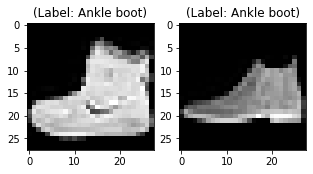

In [ ]:
plt.figure(figsize=[5,5])

# Mostramos la primera imagen del set de entrenamiento
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Mostramos la pimera imagen del set de prueba
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

####Preprocesar los datos


In [ ]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [ ]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [ ]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)
np.max(train_data), np.max(test_data)

(1.0, 1.0)

####Divido el Dataset

In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,train_data,test_size=0.2,random_state=13)

####AutoEncoder

In [ ]:
batch_size = 64
epochs = 200 #200#
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

####Trabajo

In [ ]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

####Modelamiento

In [ ]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

####Entreno el modelo

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/200
750/750 [==============================] - 75s 55ms/step - loss: 0.0198 - val_loss: 0.0100
Epoch 2/200
750/750 [==============================] - 41s 55ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 3/200
750/750 [==============================] - 41s 54ms/step - loss: 0.0068 - val_loss: 0.0086
Epoch 4/200
750/750 [==============================] - 41s 54ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 5/200
750/750 [==============================] - 41s 54ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 6/200
750/750 [==============================] - 41s 54ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 7/200
750/750 [==============================] - 41s 54ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 8/200
750/750 [==============================] - 41s 55ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/200
750/750 [==============================] - 41s 55ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/200
750/750 [==============================] - 41s 54ms/step - l

####Resultados

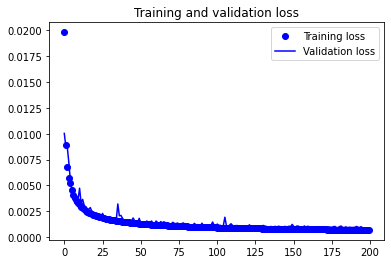

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

####Pesos

In [ ]:
autoencoder.save_weights('autoencoder.h5')

####One-Hot Encoding

In [ ]:
# Cambiar las etiquetas de categóricas a one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Muestrar el cambio para la etiqueta de categoría usando one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


###Dividir datos para entrenar autoencoder

In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

### Clasificador

#### Arquitectura

In [ ]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

#### Capa fully connected

In [ ]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

#### Modelo

In [ ]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [ ]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

####Observacion de pesos

####Autoencoder

In [ ]:
autoencoder.get_weights()[0][1]

array([[[-1.25214934e+00,  3.22454810e-01, -5.93720675e-01,
          1.97983563e-01, -2.84891911e-02,  3.48207146e-01,
          1.10143855e-01, -6.44379199e-01,  3.11613858e-01,
          3.54298502e-01,  8.89528310e-05, -3.64687920e-01,
          1.15261018e-01,  1.66535109e-01, -2.52379119e-01,
         -8.87356102e-02, -7.20938388e-03, -2.98800468e-02,
         -1.43572301e-01, -5.57898343e-01, -1.25452116e-01,
         -8.02213132e-01,  7.52612650e-01, -1.52355619e-02,
         -1.78636864e-01,  6.54918775e-02,  4.55167443e-01,
          5.14630735e-01, -2.54635271e-02, -2.54563779e-01,
          5.92666447e-01,  6.71240509e-01]],

       [[-3.26576456e-02,  5.96291244e-01,  5.09093285e-01,
          9.56379056e-01,  2.77036577e-01, -5.17527580e-01,
         -8.03515315e-01,  1.06455371e-01,  4.83967513e-01,
          2.10484907e-01, -4.13163662e-01, -8.39411795e-01,
         -1.25618234e-01,  3.43131363e-01, -6.26155376e-01,
          2.08022252e-01,  2.59423703e-01,  1.70216250

#### Clasificador

In [ ]:
full_model.get_weights()[0][1]

array([[[-1.25214934e+00,  3.22454810e-01, -5.93720675e-01,
          1.97983563e-01, -2.84891911e-02,  3.48207146e-01,
          1.10143855e-01, -6.44379199e-01,  3.11613858e-01,
          3.54298502e-01,  8.89528310e-05, -3.64687920e-01,
          1.15261018e-01,  1.66535109e-01, -2.52379119e-01,
         -8.87356102e-02, -7.20938388e-03, -2.98800468e-02,
         -1.43572301e-01, -5.57898343e-01, -1.25452116e-01,
         -8.02213132e-01,  7.52612650e-01, -1.52355619e-02,
         -1.78636864e-01,  6.54918775e-02,  4.55167443e-01,
          5.14630735e-01, -2.54635271e-02, -2.54563779e-01,
          5.92666447e-01,  6.71240509e-01]],

       [[-3.26576456e-02,  5.96291244e-01,  5.09093285e-01,
          9.56379056e-01,  2.77036577e-01, -5.17527580e-01,
         -8.03515315e-01,  1.06455371e-01,  4.83967513e-01,
          2.10484907e-01, -4.13163662e-01, -8.39411795e-01,
         -1.25618234e-01,  3.43131363e-01, -6.26155376e-01,
          2.08022252e-01,  2.59423703e-01,  1.70216250

### Ignorar parte del autoencoder

In [ ]:
# Dado que la parte del codificador ya está entrenada, no es necesario entrenarla. Solo se entrenará la parte totalmente conectada.

for layer in full_model.layers[0:19]:
    layer.trainable = False

### Compilar el modelo

In [ ]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam",metrics=['accuracy'])

In [ ]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)        1849

## Entrenamiento del modelo completo

In [ ]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
750/750 [==============================] - 11s 13ms/step - loss: 0.3715 - accuracy: 0.8729 - val_loss: 0.2886 - val_accuracy: 0.8997
Epoch 2/100
750/750 [==============================] - 9s 12ms/step - loss: 0.2261 - accuracy: 0.9173 - val_loss: 0.2821 - val_accuracy: 0.9012
Epoch 3/100
750/750 [==============================] - 9s 12ms/step - loss: 0.1779 - accuracy: 0.9342 - val_loss: 0.3133 - val_accuracy: 0.9034
Epoch 4/100
750/750 [==============================] - 9s 12ms/step - loss: 0.1529 - accuracy: 0.9431 - val_loss: 0.2979 - val_accuracy: 0.9007
Epoch 5/100
750/750 [==============================] - 9s 12ms/step - loss: 0.1335 - accuracy: 0.9494 - val_loss: 0.2933 - val_accuracy: 0.9057
Epoch 6/100
750/750 [==============================] - 9s 12ms/step - loss: 0.1134 - accuracy: 0.9577 - val_loss: 0.3198 - val_accuracy: 0.9078
Epoch 7/100
750/750 [==============================] - 10s 13ms/step - loss: 0.1046 - accuracy: 0.9608 - val_loss: 0.3388 - val_accurac

### Guardado de los pesos del modelo

In [ ]:
full_model.save_weights('autoencoder_classification.h5')

### Utilizar primera parte del modelo de nuevo

In [ ]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [ ]:
# Compilar

full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam",metrics=['accuracy'])

## Entrenamiento final

In [ ]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
750/750 [==============================] - 24s 31ms/step - loss: 0.2237 - accuracy: 0.9563 - val_loss: 0.9378 - val_accuracy: 0.8874
Epoch 2/100
750/750 [==============================] - 22s 30ms/step - loss: 0.1281 - accuracy: 0.9681 - val_loss: 0.7839 - val_accuracy: 0.9038
Epoch 3/100
750/750 [==============================] - 22s 30ms/step - loss: 0.0881 - accuracy: 0.9758 - val_loss: 0.8925 - val_accuracy: 0.9028
Epoch 4/100
750/750 [==============================] - 22s 30ms/step - loss: 0.0850 - accuracy: 0.9767 - val_loss: 1.0715 - val_accuracy: 0.9046
Epoch 5/100
750/750 [==============================] - 22s 30ms/step - loss: 0.0839 - accuracy: 0.9771 - val_loss: 0.7504 - val_accuracy: 0.9071
Epoch 6/100
750/750 [==============================] - 22s 30ms/step - loss: 0.0656 - accuracy: 0.9817 - val_loss: 0.6815 - val_accuracy: 0.9023
Epoch 7/100
750/750 [==============================] - 22s 30ms/step - loss: 0.0728 - accuracy: 0.9791 - val_loss: 1.6124 - val_ac

### Guardar pesos del modelo una vez más

In [ ]:
full_model.save_weights('classification_complete.h5')

### Resultados del entrenamiento

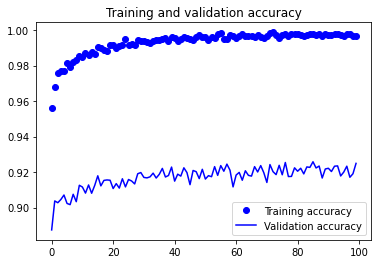

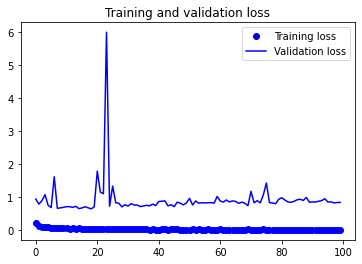

In [ ]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Evaluación del modelo en el set de prueba

In [ ]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.8786327242851257
Test accuracy: 0.9208999872207642


### Predicción

In [ ]:
predicted_classes = full_model.predict(test_data)

In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

predicted_classes.shape, test_labels.shape

((10000,), (10000,))

### Etiquetas correctas

Found 9206 correct labels


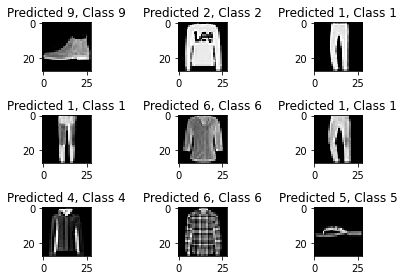

In [ ]:
correct = np.where(predicted_classes==test_labels)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

### Etiquetas incorrectas

Found 794 incorrect labels


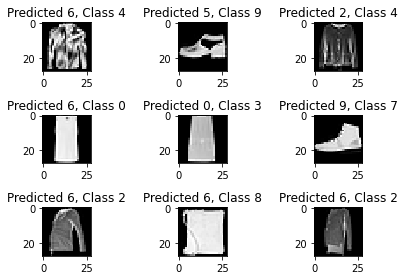

In [ ]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()